<a href="https://colab.research.google.com/github/rajak2025/googlecolab/blob/master/Debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computer Vision
## Debiasing Facial Detection Systems
In the second portion of the lab, we'll explore two prominent aspects of applied deep learning: facial detection and algorithmic bias.

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face? This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics.

we'll investigate one recently published approach to addressing algorithmic bias. We'll build a facial detection model that learns the latent variables underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigating any biases that may be present in order to train a debiased model.

Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

In [0]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 3.3MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=fbba4249ee29b8957c9e5b8ce133564a6ddb75264b4f835674312c8a18568f6d
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


# Datsets
We'll be using three datasets in this lab. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about the potential bias of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender.

**Positive training data**: CelebA Dataset. A large-scale (over 200K images) of celebrity faces.

**Negative training data**: ImageNet. Many images across many different categories. We'll take negative examples from a variety of non-human categories. Fitzpatrick Scale skin type classification system, with each image labeled as "Lighter'' or "Darker''.
Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [3]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')

# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)


1263894528/1263889489 [==============================] - 27s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [0]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Play around with displaying images to get a sense of what the training data actually looks like!

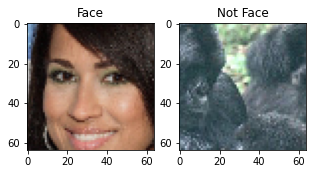

In [5]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face =  41 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face");
plt.grid(False)

#Thinking about bias
Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA and achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about latent variables, variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term latent space to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier biased if its classification decision changes after it sees some additional latent features.

#CNN for facial detection
First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

#Define and train the CNN model
Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets using the tf.GradientTape class and the tf.GradientTape.gradient method.

In [0]:
### Define the CNN model ##
n_filters = 12 # base number of convolutional filters

''' Function to define a standard CNN Model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding ='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  model = tf.keras.Sequential([
      Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
      BatchNormalization(),

      Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
      BatchNormalization(),

      Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
      BatchNormalization(),

      Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
      BatchNormalization(),

      Flatten(),
      Dense(512),
      Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()


Now let's train the standard CNN!

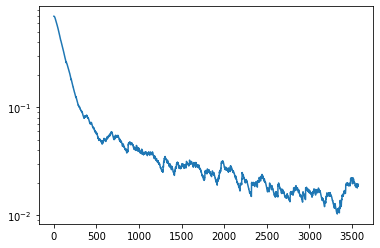

  4%|▍         | 150/3434 [00:11<04:02, 13.53it/s]

KeyboardInterrupt: ignored

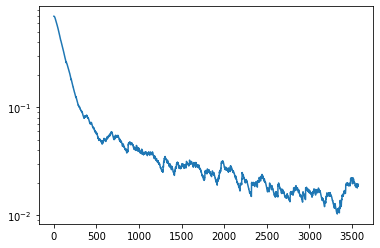

In [7]:
### Train the standard CNN ###
# Training hyperparameters
batch_size = 32
num_epochs = 2 # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) #define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor = 0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x,y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

    #Backpropagation 
    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab the batch of training data and propagate through the network

    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())